In [1]:
!pip3 install handyspark

You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
from handyspark import *

In [3]:
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import ParamGridBuilder, TrainValidationSplit
from pyspark.ml.feature import OneHotEncoderEstimator, StringIndexer, VectorAssembler, StandardScaler
from pyspark.ml import Pipeline
from pyspark.mllib.stat import Statistics
from pyspark.ml.linalg import DenseVector
from pyspark.sql import functions as F

In [4]:
import random
import numpy as np
from pyspark.sql import Row
from sklearn import neighbors
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.stat import Statistics

In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
from pyspark.sql import SparkSession

In [7]:
spark = SparkSession\
    .builder\
    .appName("LC_Baseline_Model")\
    .config("spark.executor.memory","2g")\
    .config("spark.executor.cores","8")\
    .config("spark.driver.memory","2g")\
    .getOrCreate()

In [8]:
def vectorizerFunction(dataInput, TargetFieldName):
    if(dataInput.select(TargetFieldName).distinct().count() != 2):
        raise ValueError("Target field must have only 2 distinct classes")
    columnNames = list(dataInput.columns)
    columnNames.remove(TargetFieldName)
    dataInput = dataInput.select((','.join(columnNames)+','+TargetFieldName).split(','))
    assembler=VectorAssembler(inputCols = columnNames, outputCol = 'features')
    pos_vectorized = assembler.transform(dataInput)
    vectorized = pos_vectorized.select('features',TargetFieldName).withColumn('label',pos_vectorized[TargetFieldName]).drop(TargetFieldName)
    return vectorized

In [9]:
def SmoteSampling(vectorized, k = 5, minorityClass = 1, majorityClass = 0, percentageOver = 200, percentageUnder = 100):
    if(percentageUnder > 100|percentageUnder < 10):
        raise ValueError("Percentage Under must be in range 10 - 100");
    if(percentageOver < 100):
        raise ValueError("Percentage Over must be in at least 100");
    dataInput_min = vectorized[vectorized['label'] == minorityClass]
    dataInput_maj = vectorized[vectorized['label'] == majorityClass]
    feature = dataInput_min.select('features')
    feature = feature.rdd
    feature = feature.map(lambda x: x[0])
    feature = feature.collect()
    feature = np.asarray(feature)
    nbrs = neighbors.NearestNeighbors(n_neighbors=k, algorithm='auto').fit(feature)
    neighbours =  nbrs.kneighbors(feature)
    gap = neighbours[0]
    neighbours = neighbours[1]
    min_rdd = dataInput_min.drop('label').rdd
    pos_rddArray = min_rdd.map(lambda x : list(x))
    pos_ListArray = pos_rddArray.collect()
    min_Array = list(pos_ListArray)
    newRows = []
    nt = len(min_Array)
    nexs = percentageOver//100
    for i in range(nt):
        for j in range(nexs):
            neigh = random.randint(1,k)
            difs = min_Array[neigh][0] - min_Array[i][0]
            newRec = (min_Array[i][0]+random.random()*difs)
            newRows.insert(0,(newRec))
    newData_rdd = spark.sparkContext.parallelize(newRows)
    newData_rdd_new = newData_rdd.map(lambda x: Row(features = x, label = 1))
    new_data = newData_rdd_new.toDF()
    new_data_minor = dataInput_min.unionAll(new_data)
    new_data_major = dataInput_maj.sample(False, (float(percentageUnder)/float(100)))
    return new_data_major.unionAll(new_data_minor)

In [10]:
df = spark.read.option('inferschema','true').csv('data/Data_Exploration.csv', header=True)

In [11]:
df = df.limit(20000)

In [12]:
df_pd = df.groupby("is_default").count().toPandas()

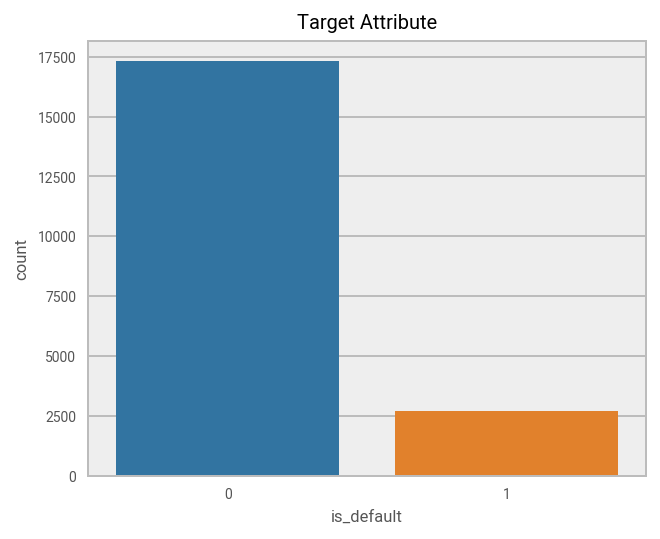

In [13]:
import seaborn as sns
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(5,4))
sns.barplot(x=df_pd["is_default"], y=df_pd["count"]).set(title="Target Attribute")
plt.show()

In [14]:
df.dtypes

[('acc_now_delinq', 'int'),
 ('acc_open_past_24mths', 'int'),
 ('addr_state', 'string'),
 ('annual_inc', 'double'),
 ('application_type', 'string'),
 ('avg_cur_bal', 'int'),
 ('chargeoff_within_12_mths', 'int'),
 ('collections_12_mths_ex_med', 'int'),
 ('delinq_2yrs', 'int'),
 ('delinq_amnt', 'int'),
 ('dti', 'double'),
 ('earliest_cr_line', 'string'),
 ('emp_length', 'string'),
 ('funded_amnt', 'int'),
 ('funded_amnt_inv', 'double'),
 ('grade', 'string'),
 ('home_ownership', 'string'),
 ('initial_list_status', 'string'),
 ('inq_last_6mths', 'int'),
 ('installment', 'double'),
 ('int_rate', 'double'),
 ('issue_d', 'string'),
 ('loan_amnt', 'int'),
 ('loan_status', 'string'),
 ('mo_sin_old_rev_tl_op', 'int'),
 ('mo_sin_rcnt_rev_tl_op', 'int'),
 ('mo_sin_rcnt_tl', 'int'),
 ('mort_acc', 'int'),
 ('num_accts_ever_120_pd', 'int'),
 ('num_actv_bc_tl', 'int'),
 ('num_actv_rev_tl', 'int'),
 ('num_bc_sats', 'int'),
 ('num_bc_tl', 'int'),
 ('num_il_tl', 'int'),
 ('num_op_rev_tl', 'int'),
 ('num_

In [15]:
#We will drop this feature based on its imbalance
df.groupby('application_type').count().show()

+----------------+-----+
|application_type|count|
+----------------+-----+
|      Individual|19851|
|       Joint App|  149|
+----------------+-----+



In [16]:
#We will drop this feature for now although it could be one hot encoded or transformed differently
df.select('emp_length').show(5)

+----------+
|emp_length|
+----------+
| 10+ years|
|    1 year|
| 10+ years|
|   2 years|
|  < 1 year|
+----------+
only showing top 5 rows



In [17]:
#We keep this feature
df.groupby('verification_status').count().show()

+-------------------+-----+
|verification_status|count|
+-------------------+-----+
|       Not Verified| 6489|
|           Verified| 5904|
|    Source Verified| 7607|
+-------------------+-----+



In [18]:
#We remove categorical features that have too broad a set of values, or are highly imbalanced, or could cause data leakage. 
#We can elaborate and use them for feature extraction later, but they are not needed for a baseline
remove = ['addr_state', 'earliest_cr_line', 'home_ownership', 'initial_list_status', 'issue_d', 'emp_length',
          'loan_status', 'purpose', 'sub_grade', 'term', 'title', 'zip_code', 'application_type']
df = df.drop(*remove)

Baseline Feature Exploration

In [19]:
#Creating list of categorical and numeric features
cat_cols = [item[0] for item in df.dtypes if item[1].startswith('string')]
num_cols = [item[0] for item in df.dtypes if item[1].startswith('in') or item[1].startswith('dou')]

In [20]:
cat_cols

['grade', 'verification_status']

In [21]:
len(cat_cols+num_cols)

51

In [22]:
#Creating a subset of the data with only numeric features:
df_num = df.select(num_cols)

In [23]:
features = df_num.rdd.map(lambda row: row[0:])

In [24]:
corr_mat=Statistics.corr(features, method="pearson")
corr_df = pd.DataFrame(corr_mat)

In [25]:
corr_df.index, corr_df.columns = df_num.columns, df_num.columns

In [26]:
#Dropping code features that are in numeric datatype (these are really categorical):
corr_df = corr_df.drop(['dti', 'num_rev_accts', 'policy_code', 'revol_util'], axis=1)
corr_df = corr_df.drop(['dti', 'num_rev_accts', 'policy_code', 'revol_util'], axis=0)

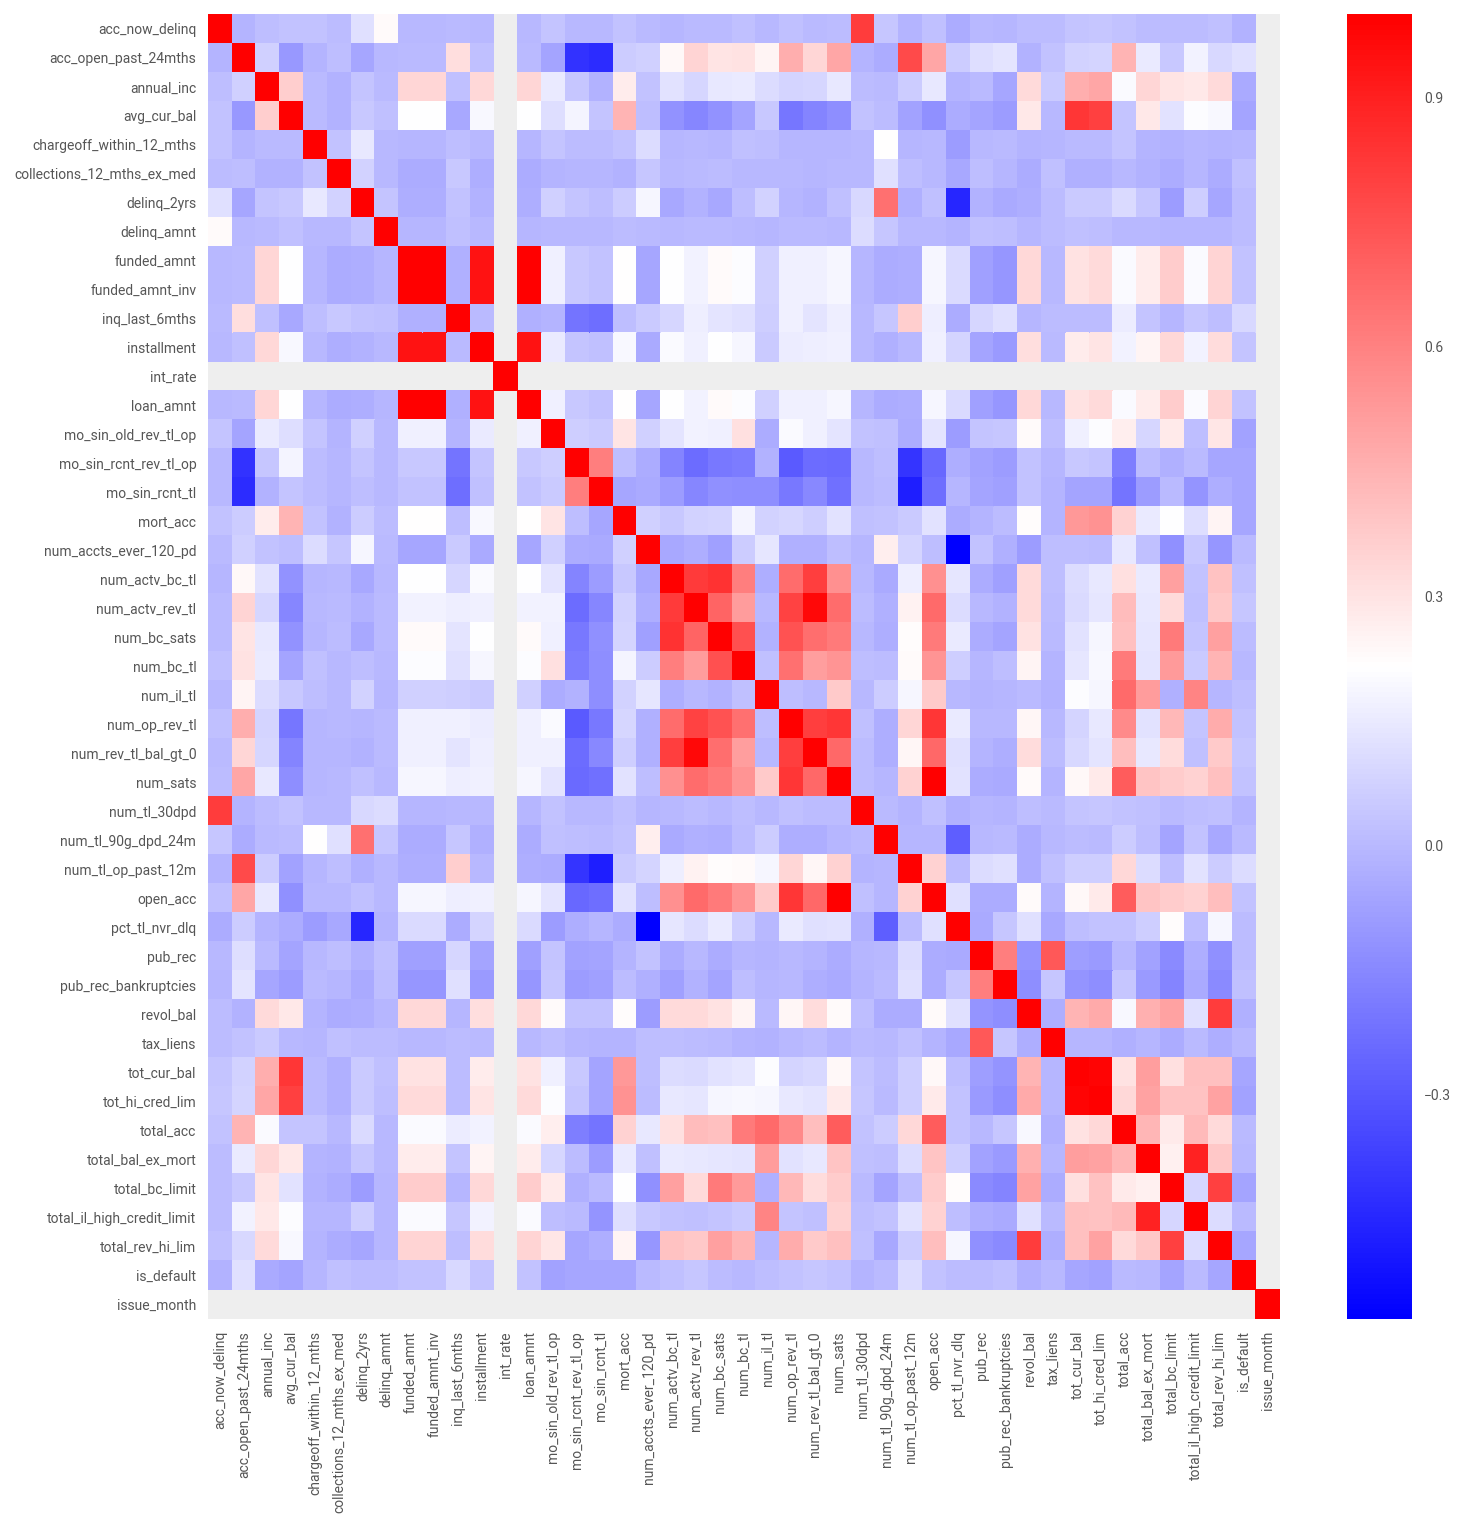

In [27]:
#Correlation Matrix between numeric columns
fig, ax = plt.subplots(figsize=(12,12))
sns.heatmap(corr_df, cbar=True, ax=ax, cmap='bwr')
plt.show()

In [28]:
#We will choose these features for our baseline model:
num_features, cat_features = num_cols, cat_cols

In [29]:
#Count number of nulls for each column:
nulls = df.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

In [30]:
nulls.T[(nulls.T > 0).any(axis=1)].index

Index(['dti', 'int_rate', 'revol_util'], dtype='object')

In [31]:
impute_list = list(nulls.T[(nulls.T > 0).any(axis=1)].index)

In [32]:
#Both attributes are continuous so we will impute

In [33]:
from pyspark.ml.feature import Imputer

In [34]:
imputer = Imputer(inputCols=impute_list, outputCols=[i+"_imp" for i in impute_list])

In [35]:
model = imputer.fit(df)

In [36]:
df = model.transform(df)

In [39]:
num_features+=[i+"_imp" for i in impute_list]

In [40]:
num_features = [i for i in num_features if i not in impute_list]

In [61]:
num_features.remove("is_default")

In [41]:
#Creates a Pipeline Object including One Hot Encoding of Categorical Features  
def make_pipeline(spark_df, num_att, cat_att):        
    stages= []

    for col in cat_att:

        stringIndexer = StringIndexer(inputCol = col , outputCol = col + '_StringIndex')
        encoder = OneHotEncoderEstimator(inputCols=[stringIndexer.getOutputCol()], outputCols=[col + '_ClassVect'])
        stages += [stringIndexer, encoder]

    #Assembling mixed data type transformations:
    assemblerInputs = [c + "_ClassVect" for c in cat_att] + num_att
    assembler = VectorAssembler(inputCols=assemblerInputs, outputCol="features")

    stages += [assembler]

    #Creating and running the pipeline:
    pipeline = Pipeline(stages=stages)
    pipelineModel = pipeline.fit(spark_df)
    out_df = pipelineModel.transform(spark_df)
    
    return out_df

In [62]:
df_model = make_pipeline(df, num_features, cat_features)

In [63]:
input_data = df_model.rdd.map(lambda x: (x["is_default"], DenseVector(x["features"])))

In [64]:
df_baseline = spark.createDataFrame(input_data, ["is_default", "features"])

In [65]:
df_baseline.show(5)

+----------+--------------------+
|is_default|            features|
+----------+--------------------+
|         0|[1.0,0.0,0.0,0.0,...|
|         0|[1.0,0.0,0.0,0.0,...|
|         1|[0.0,1.0,0.0,0.0,...|
|         0|[1.0,0.0,0.0,0.0,...|
|         0|[1.0,0.0,0.0,0.0,...|
+----------+--------------------+
only showing top 5 rows



In [66]:
#Scaling Data prior to SMOTE

In [67]:
scaler = StandardScaler(inputCol="features", outputCol="scaledFeatures", withStd=True, withMean=True)

In [68]:
scalerModel = scaler.fit(df_baseline)

In [69]:
scaledData = scalerModel.transform(df_baseline)

In [70]:
scaledData = scaledData.drop("features")

In [71]:
scaledData.show(5)

+----------+--------------------+
|is_default|      scaledFeatures|
+----------+--------------------+
|         0|[1.51145537946020...|
|         0|[-0.6615808932163...|
|         0|[-0.6615808932163...|
|         0|[-0.6615808932163...|
|         0|[-0.6615808932163...|
+----------+--------------------+
only showing top 5 rows



In [72]:
#column_names
temp = scaledData.rdd.map(lambda x:[float(y) for y in x['scaledFeatures']]).toDF(num_features + cat_features)

In [73]:
#Notice we now have 56 columns rather than 50 - we have one hot encoded our categorical features
len(temp.columns)

56

In [74]:
cols = list(df.columns)
cols.remove("is_default")

In [75]:
import pyspark.sql.functions as sparkf

# This will return a new DF with all the columns + id
df_join = df.withColumn('id', sparkf.monotonically_increasing_id())
temp = temp.withColumn('id', sparkf.monotonically_increasing_id())

In [76]:
df_join = df_join.select('id', 'is_default')

In [77]:
temp = temp.join(df_join, temp.id == df_join.id, 'inner').drop(df_join.id).drop(temp.id)

In [78]:
#Smote

In [79]:
df_smote = SmoteSampling(vectorizerFunction(temp, 'is_default'), k = 2, minorityClass = 1, majorityClass = 0, percentageOver = 400, percentageUnder = 100)

In [80]:
df_smote.show(5)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.51145537946020...|    0|
|[-0.6615808932163...|    0|
|[-0.6615808932163...|    0|
|[-0.6615808932163...|    0|
|[1.51145537946020...|    0|
+--------------------+-----+
only showing top 5 rows



In [81]:
#The original dataframe
df.groupby("is_default").count().show()

+----------+-----+
|is_default|count|
+----------+-----+
|         0|17329|
|         1| 2671|
+----------+-----+



In [82]:
#The upsampled dataframe - notice the distribution of the label attribute is much more similar
df_smote.groupby("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|17295|
|    1|13376|
+-----+-----+



In [83]:
df_smote_pd = df_smote.groupby("label").count().toPandas()

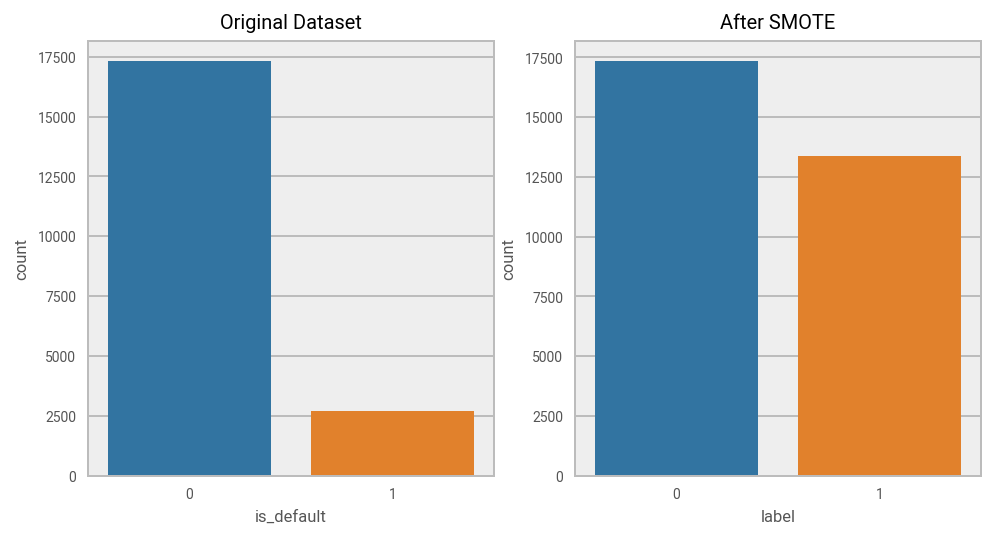

In [84]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4), sharex=False)

ax1 = sns.barplot(x=df_pd["is_default"], y=df_pd["count"], ax=ax1).set(title="Original Dataset")

ax2 = sns.barplot(x=df_smote_pd["label"],y=df_smote_pd["count"], ax=ax2).set(title="After SMOTE")
plt.show()

#### Baseline Model

In [85]:
#Using stratified sampling to get the same percentage of target class instances between the two sets

In [86]:
df_smote.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10).show(2)

+--------------------+-----+
|            features|label|
+--------------------+-----+
|[1.51145537946020...|    0|
|[1.51145537946020...|    0|
+--------------------+-----+
only showing top 2 rows



In [87]:
train = df_smote.sampleBy("label", fractions={0: 0.8, 1: 0.8}, seed=10)

In [88]:
test = df_smote.subtract(train)

In [90]:
#Saving the training df so it can be reused later
train_df = train.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(cols)
train_label = train.rdd.map(lambda x: (x['label'], )).toDF(["label"])
# This will return a new DF with all the columns + id
train_df = train_df.withColumn('id', sparkf.monotonically_increasing_id())
train_label = train_label.withColumn('id', sparkf.monotonically_increasing_id())
train_df = train_df.join(train_label, train_df.id == train_label.id, 'inner').drop(train_df.id).drop(train_label.id)
train_df.toPandas().to_csv('data/baseline/smote_training.csv', index=False)

In [91]:
#Saving the test df so it can be reused later
test_df = test.rdd.map(lambda x:[float(y) for y in x['features']]).toDF(cols)
test_label = test.rdd.map(lambda x: (x['label'], )).toDF(["label"])
# This will return a new DF with all the columns + id
test_df = test_df.withColumn('id', sparkf.monotonically_increasing_id())
test_label = test_label.withColumn('id', sparkf.monotonically_increasing_id())
test_df = test_df.join(test_label, test_df.id == test_label.id, 'inner').drop(test_df.id).drop(test_label.id)
test_df.toPandas().to_csv('data/baseline/smote_test.csv', index=False)

In [92]:
#The label counts for the training set 
train.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0|13851|
|    1|10729|
+-----+-----+



In [93]:
#The label counts for the test set
test.groupBy("label").count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3457|
|    1| 2646|
+-----+-----+



Logistic Regression

In [94]:
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10, regParam=0.3, elasticNetParam=0.4)

In [95]:
# Fit the model
lrModel = lr.fit(train)

In [96]:
# Print the coefficients and intercept for logistic regression
print("Coefficients: " + str(lrModel.coefficients))
print("\n")
print("Intercept: " + str(lrModel.intercept))

Coefficients: (56,[3,21,37,52,54],[0.01455239267149009,-0.00803483837863072,0.030956345321468768,-0.01079426634832821,0.1448246245254332])


Intercept: -0.2994694165900668


In [97]:
# Make predictions on test data. model is the model with combination of parameters that performed best.
predictions = lrModel.transform(test)

In [98]:
predictions.show(5)

+--------------------+-----+--------------------+--------------------+----------+
|            features|label|       rawPrediction|         probability|prediction|
+--------------------+-----+--------------------+--------------------+----------+
|[-0.6615808932163...|    0|[0.07465495318646...|[0.51865507481085...|       0.0|
|[-0.6615808932163...|    0|[0.01264461681939...|[0.50316111208674...|       0.0|
|[-0.6615808932163...|    0|[0.11145293056276...|[0.52783442590071...|       0.0|
|[-0.6615808932163...|    1|[0.01145603301856...|[0.50286397693218...|       0.0|
|[-0.6615808932163...|    1|[0.02478822084040...|[0.50619673791150...|       0.0|
+--------------------+-----+--------------------+--------------------+----------+
only showing top 5 rows



In [99]:
predictions.select("label", "prediction").groupby('label').count().show()

+-----+-----+
|label|count|
+-----+-----+
|    0| 3457|
|    1| 2646|
+-----+-----+



In [100]:
predictions.select("label", "prediction").groupby('prediction').count().show()

+----------+-----+
|prediction|count|
+----------+-----+
|       0.0| 5867|
|       1.0|  236|
+----------+-----+



In [101]:
preds_df = predictions.select("label", "prediction")
predictions.select("label", "prediction").filter(preds_df.prediction == preds_df.prediction).count() / preds_df.count()

0.9996722923152548

Model Evaluation

In [102]:
evaluator = BinaryClassificationEvaluator(labelCol="label", rawPredictionCol="prediction")

In [103]:
auroc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderROC"})
auprc = evaluator.evaluate(predictions, {evaluator.metricName: "areaUnderPR"})

In [104]:
print("Area under ROC Curve: {:.4f}".format(auroc))
print("Area under PR Curve: {:.4f}".format(auprc))

Area under ROC Curve: 0.5106
Area under PR Curve: 0.5041


In [105]:
# Handy Spark Library 
# Creates instance of extended version of BinaryClassificationMetrics
# using a DataFrame and its probability and label columns, as the output
# from the classifier
bcm = BinaryClassificationMetrics(predictions, scoreCol='probability', labelCol='label')

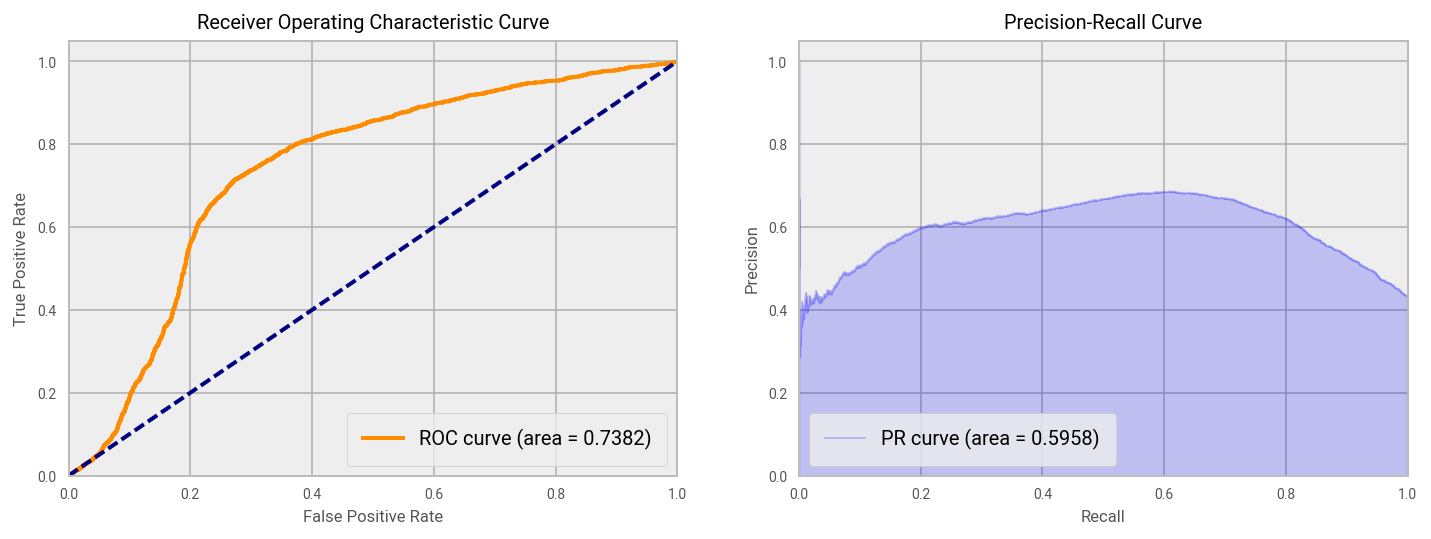

In [106]:
# Now we can PLOT both ROC and PR curves!
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
bcm.plot_roc_curve(ax=axs[0])
bcm.plot_pr_curve(ax=axs[1])
plt.show()

In [107]:
# And get the confusion matrix for any threshold we want
cm = bcm.print_confusion_matrix(.50)

In [108]:
from confusion_matrix_pretty_print import pretty_plot_confusion_matrix

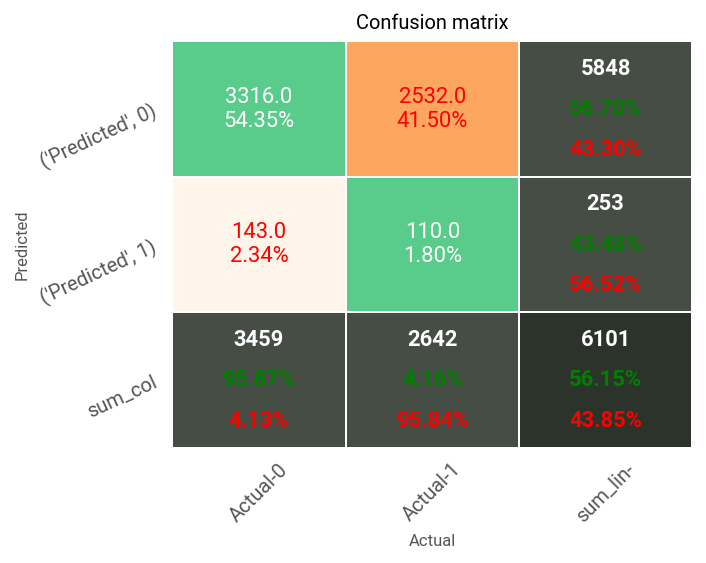

In [109]:
pretty_plot_confusion_matrix(cm, figsize=[5,4])
plt.show()

In [115]:
#We assign a cost to each of the four items in the quadrant
fp_cost = 10
fn_cost = 1600
tp_cost = 0
tn_cost = 100

In [116]:
#We assign a financial gain to true positives
tn_gain = 2000

In [117]:
def campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tp = cm.iloc[1,1]
    num_tn = cm.iloc[0,0]
    num_fp = cm.iloc[0,1]
    num_fn = cm.iloc[1,0]
    
    #Calculate total costs:
    campaign_cost = num_tp*tp_cost + num_tn*tn_cost + num_fp*fp_cost + num_fn*fn_cost
    campaign_gain = num_tn*tn_gain - campaign_cost
    
    print("The estimate campaign outcome with all customers is: ", campaign_gain, " with Decision Threshold: ", thres)
    return campaign_gain

In [118]:
def campaign_outcome_predicted(cm, fn_cost, tn_cost, tn_gain, thres):
    
    # We can obtain the confusion matrix for any arbitrary threshold 
    cm = bcm.print_confusion_matrix(thres)
    
    #Quantify true/false positives and negatives 
    num_tn = cm.iloc[0,0]
    num_fn = cm.iloc[1,0]
    
    #Calculate total costs:
    campaign_cost = num_tn*tn_cost + num_fn*fn_cost 
    campaign_gain = num_tn*tn_gain - campaign_cost
    
    print("The estimate campaign outcome with selected customers is: ", campaign_gain, " with Decision Threshold: ", thres)
    return campaign_gain

In [119]:
campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, 0.5)

The estimate campaign outcome with all customers is:  2247770.0  with Decision Threshold:  0.5


2247770.0

In [120]:
campaign_outcome_predicted(cm, fn_cost, tp_cost, tn_gain, 0.5)

The estimate campaign outcome with selected customers is:  2580800.0  with Decision Threshold:  0.5


2580800.0

In [121]:
gains_all = []
gains_predicted = []
for thres in np.arange(0,1,0.1):
    campaign_gain_all = campaign_outcome_all(cm, fn_cost, fp_cost, tp_cost, tn_cost, tn_gain, thres)
    campaign_gain_predicted = campaign_outcome_predicted(cm, fn_cost, tp_cost, tn_gain, thres)
    gains_all.append((thres, campaign_gain_all))
    gains_predicted.append((thres, campaign_gain_predicted))

The estimate campaign outcome with all customers is:  -34590.0  with Decision Threshold:  0.0
The estimate campaign outcome with selected customers is:  0.0  with Decision Threshold:  0.0
The estimate campaign outcome with all customers is:  -34590.0  with Decision Threshold:  0.1
The estimate campaign outcome with selected customers is:  0.0  with Decision Threshold:  0.1
The estimate campaign outcome with all customers is:  -34590.0  with Decision Threshold:  0.2
The estimate campaign outcome with selected customers is:  0.0  with Decision Threshold:  0.2
The estimate campaign outcome with all customers is:  -34590.0  with Decision Threshold:  0.30000000000000004
The estimate campaign outcome with selected customers is:  0.0  with Decision Threshold:  0.30000000000000004
The estimate campaign outcome with all customers is:  1500680.0  with Decision Threshold:  0.4
The estimate campaign outcome with selected customers is:  1619600.0  with Decision Threshold:  0.4
The estimate campaign

In [122]:
df_all = pd.DataFrame(gains_all, columns=['Threshold', 'NetCampaignContribution_ALL']).set_index('Threshold')
df_predicted = pd.DataFrame(gains_predicted, columns=['Threshold', 'NetCampaignContribution_SELECTED']).set_index('Threshold')

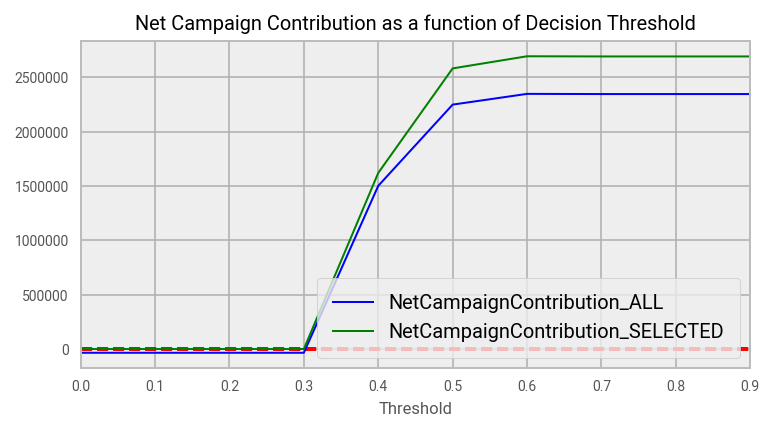

In [123]:
f, ax = plt.subplots(1, figsize=(6,3))
df_all.plot(ax=ax, color='b', markeredgewidth=10)
df_predicted.plot(ax=ax, color='g', markeredgewidth=10)
xs = np.linspace(1, 21, 200)
plt.hlines(y=40, xmin=0, xmax=len(xs), color='r', linestyles='--', lw=2)
ax.set_title("Net Campaign Contribution as a function of Decision Threshold")
plt.ticklabel_format(style = 'plain')
plt.show()

In [124]:
#Saving the predictions

In [125]:
input_data = predictions.rdd.map(lambda x: (x["is_default"], DenseVector(x["probability"])))

In [126]:
temp = predictions.rdd.map(lambda x:(x["label"], [float(y) for y in x['probability']])).toDF(["label", "probability"])

In [127]:
temp = temp.toPandas()

In [128]:
temp = pd.DataFrame(temp.probability.apply(pd.Series).join(temp, how='inner'))

In [129]:
temp.columns = ['prob0', 'prob1', 'label', 'probability']

In [130]:
temp = temp.drop(columns=['prob0', 'probability'])

In [131]:
temp.to_csv("data/baseline/predictions/label_vs_pred.csv")